In [1]:
import pandas as pd 
import numpy as np
from tqdm import tqdm
from scipy.stats import zscore, spearmanr, rankdata
from statsmodels.formula.api import ols

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [9, 5]

import os
import sys
sys.path.append('../')
from alpha_191 import Alpha191

import warnings
warnings.filterwarnings('ignore')

import feather

### 读取自存数据

In [2]:
universe = feather.read_dataframe('bitcoin_data/raw36_20220301_now.feather')
universe = universe.drop(columns=['close time'])
universe['date'] = pd.to_datetime(universe['date'],format='%Y-%m-%d %H:%M:%S')
universe = universe.set_index(['date']).sort_values(by=['date', 'ts_code'])

In [3]:
universe['vwap'] = universe['amount']/universe['volume']
universe = universe.rename(columns={'open':'open_usdt', 'high':'high_usdt', 'low':'low_usdt', 
                                    'close':'close_usdt', 'vwap':'vwap_usdt'})

In [4]:
def my_groupby(df, column, func, sort_keys=['date', 'ts_code']):
    all_df = pd.DataFrame()
    for val in tqdm(df[column].unique()):
        tmp = df.loc[df[column] == val]
        all_df = all_df.append(func(tmp))
    return all_df.sort_index(level=sort_keys)

In [5]:
def convert_price_to_returns(df):
    def cal_(data):
        data['close'] = data['close_usdt'].pct_change()
        data['close'] = (data['close'].fillna(0) + 1).cumprod()
        data['vwap'] = data['vwap_usdt'].pct_change()
        data['vwap'] = (data['vwap'].fillna(0) + 1).cumprod()
        
        for feature in ['open', 'high', 'low',]:
            data[feature] = data[feature + '_usdt']/data['close_usdt'] * data['close']
        return data
    
    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = convert_price_to_returns(universe)

100%|███████████████████████████████████████████| 36/36 [00:02<00:00, 17.93it/s]


In [6]:
universe['trade_date'] = universe.index

<AxesSubplot:xlabel='date'>

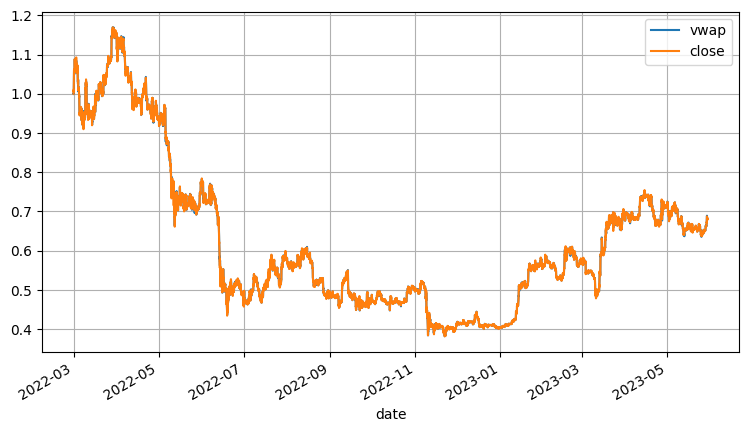

In [7]:
universe.loc[(universe.ts_code=='BTCUSDT')][['vwap', 'close']].plot(grid=True)

### 构造指数

### 读取网盘数据
选取2021-04 至 2023-03月数据 频率为4H

In [ ]:
folder_path = 'bitcon/tlkjdata/'  # 替换为实际的文件夹路径

file_list = []  # 存储文件的列表

# 遍历文件夹下的所有文件
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)  # 构建文件的完整路径
    if os.path.isfile(file_path):  # 确保当前路径是文件而不是文件夹
        file_list.append(file_path)  # 将文件路径添加到列表中

In [ ]:
def sum_volume(series):
    return series.sum()

universe = pd.DataFrame()
for path in tqdm(file_list):
    df = feather.read_dataframe(path)
    df = df.rename(columns={'vol':'volume'})
    df[['open','close','high','low','volume']] = df[['open','close','high','low','volume']].astype(np.float32)
    half_day_data = df.set_index(['date']).resample('2H').agg({
                    'open':'first', 'high':'max', 'low':'min', 'close':'last', 'volume':sum_volume})
    start_time = pd.to_datetime('2022-01-01')
    end_time = pd.to_datetime('2023-03-28')
    half_day_data = half_day_data[(half_day_data.index >= start_time) & (half_day_data.index <= end_time)]
    exist_time = (end_time - half_day_data.index[0]).days
    if exist_time <= 260:
        continue
    half_day_data['ts_code'] = path.split('_')[0].split('/')[2]
    universe = universe.append(half_day_data)

### 构造技术指标为alpha

In [8]:
import stockstats

class IndicatorHelper(pd.DataFrame):
    """
        add indicators to dataframe
    """

    def __init__(self, data):
        super(IndicatorHelper, self).__init__(data)

        self.stocks = stockstats.StockDataFrame.retype(data.copy())
        self.df = self

    def add_technical_indicator(self, tech_indicator_list):
        """
        calculate technical indicators
        use stockstats package to add technical inidactors
        :param ticker: (df) pandas dataframe
        :param tech_indeicator_list list
        :return: (df) pandas dataframe
        """
        unique_ticker = self.df.ts_code.unique()

        indicator_df = pd.DataFrame()
        for i in tqdm(range(len(unique_ticker)), desc='add tech indicators'):
            temp_indicator = self.stocks[self.stocks.ts_code == unique_ticker[i]]
            temp_indicator = temp_indicator[tech_indicator_list + ['ts_code', 'trade_date']]
            indicator_df = indicator_df.append(temp_indicator, ignore_index=True)
        
        self.df = self.df.merge(indicator_df, on=["ts_code", "trade_date"], how="left")
        self.df['date'] = self.df['trade_date'].apply(lambda x: pd.Timestamp(x))
        self.df = self.df.set_index(['date']).sort_values(by=['date', 'ts_code'])
        return self.df
    

In [9]:
# add tech indicators
tech_indicator_list = ['log-ret','wt1', 'wt2','stochrsi_6', 'cci_6', 'rsi_6', 'atr'] 
universe = IndicatorHelper(universe).add_technical_indicator(tech_indicator_list)

add tech indicators: 100%|██████████████████████| 36/36 [03:18<00:00,  5.50s/it]


In [4]:
universe['alpha_atr'] = -universe['atr']
universe['alpha_wt'] = -(universe['wt1'] - universe['wt2'])
universe['alpha_cci'] = -universe['cci_6']
universe['alpha_srsi'] = -universe['stochrsi_6']
universe['alpha_rsi'] = -universe['rsi_6']

In [6]:
def Corr(data, win_len):
    obj = data.rolling(window=win_len, method='table')
    s = []
    for o in obj:
        if o.shape[0] < win_len:
            s.append(0.)
        else:
            s.append(spearmanr(o.iloc[:, 0], o.iloc[:, 1])[0])
            # s.append(o.iloc[:, 0].corr(o.iloc[:, 1]))
    return pd.DataFrame(s, index=data.index, columns=['corr'])

def delta(df, period=1):
    return df.diff(period)

def ts_rank(data, window=10):
    return data.rolling(window).apply(lambda x: rankdata(x)[-1])

def sma(df, window=10):
    return df.rolling(window).mean()

def ESma(sr, n, m):
    return sr.ewm(alpha=m / n, adjust=False).mean()

def Regbeta(sr, x):
    window = len(x)
    return sr.rolling(window).apply(lambda y: np.polyfit(x, y, deg=1)[0])

def Sequence(n):
    return np.arange(1, n + 1)

def Decaylinear(sr, window):
    weights = np.array(range(1, window + 1))
    sum_weights = np.sum(weights)
    return sr.rolling(window).apply(lambda x: np.sum(weights * x) / sum_weights)

def my_groupby(df, column, func, sort_keys=['date', 'ts_code']):
    all_df = pd.DataFrame()
    for val in tqdm(df[column].unique()):
        tmp = df.loc[df[column] == val]
        all_df = all_df.append(func(tmp))
    return all_df.sort_values(by=sort_keys)

In [7]:
def alpha_t1(df):
    def cal_(data):
        data['alpha_t1'] = (data['close'].rolling(4).mean() - data['close'].rolling(20).mean())\
                            /data['close'].rolling(20).std()
        data['alpha_t1'] = -data['alpha_t1'] - data['rsi_6'] * 0.2
        return data
    
    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = alpha_t1(universe) 

100%|███████████████████████████████████████████| 36/36 [00:03<00:00, 10.28it/s]


In [14]:
def alpha_t2(df):
    def cal_(data):
        data['alpha_t2'] = -data['log-ret']/ (data['close'].rolling(6).max() - data['close'].rolling(6).min())
        return data
    
    df = my_groupby(df, 'ts_code', cal_)
    return df
universe = alpha_t2(universe) 

100%|███████████████████████████████████████████| 36/36 [00:02<00:00, 13.56it/s]


In [15]:
def alpha_t3(df):
    def cal_(data):
        data['alpha_t3'] = data['log-ret'].rolling(4).sum()/(data['high'] - data['low']).rolling(12).sum()
        return data
    
    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = alpha_t3(universe)

100%|███████████████████████████████████████████| 36/36 [00:02<00:00, 14.46it/s]


In [8]:
def alpha_t4(df):
    def cal_(data):
        wave = data['high'].rolling(12).max() - data['low'].rolling(12).min()
        data['alpha_t4'] = -(data['close'] - data['low'].rolling(4).mean())/wave
        return data
    
    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = alpha_t4(universe)

100%|███████████████████████████████████████████| 36/36 [00:03<00:00,  9.93it/s]


In [18]:
def alpha077(df):
    def cal_(df):
        df['alpha_077'] = (df['high'] + df['low']) / 2 - df['vwap']
        df['alpha_077'] = Decaylinear(df['alpha_077'], 12)
        return df
    
    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = alpha077(universe) 

100%|███████████████████████████████████████████| 36/36 [02:03<00:00,  3.42s/it]


In [19]:
alpha = Alpha191(universe, None, True)

In [20]:
universe = alpha.alpha006(alpha.df)

In [21]:
universe = alpha.alpha007(alpha.df)

In [22]:
universe = alpha.alpha008(alpha.df)

In [23]:
universe = alpha.alpha012(alpha.df)

In [24]:
universe = alpha.alpha018(alpha.df)

In [25]:
universe = alpha.alpha019(alpha.df)

In [26]:
universe = alpha.alpha021(alpha.df)

alpha021 processing...: 100%|███████████████████| 36/36 [01:18<00:00,  2.17s/it]


In [27]:
universe = alpha.alpha029(alpha.df)

In [28]:
universe = alpha.alpha061(alpha.df)

processing...: 100%|████████████████████████████| 36/36 [09:29<00:00, 15.82s/it]


In [29]:
universe = alpha.alpha078(alpha.df)

In [30]:
universe = alpha.alpha101(alpha.df)

processing...: 100%|████████████████████████████| 36/36 [10:35<00:00, 17.67s/it]


In [31]:
universe = alpha.alpha111(alpha.df)

In [32]:
universe = alpha.alpha112(alpha.df)

In [33]:
universe = alpha.alpha131(alpha.df)

processing1...: 100%|███████████████████████████| 36/36 [07:43<00:00, 12.88s/it]


In [34]:
universe = alpha.alpha176(alpha.df)

processing...: 100%|████████████████████████████| 36/36 [05:17<00:00,  8.82s/it]


In [35]:
alpha.df = universe.copy(deep=True)
bak = universe.copy(deep=True)

In [36]:
universe.columns

Index(['open_usdt', 'high_usdt', 'low_usdt', 'close_usdt', 'volume', 'amount',
       'trade_counts', 'buy_volume', 'buy_amount', 'ts_code', 'vwap_usdt',
       'close', 'vwap', 'open', 'high', 'low', 'trade_date', 'log-ret', 'wt1',
       'wt2', 'stochrsi_6', 'cci_6', 'rsi_6', 'atr', 'alpha_atr', 'alpha_wt',
       'alpha_cci', 'alpha_srsi', 'alpha_rsi', 'alpha_t1', 'alpha_t2',
       'alpha_t3', 'alpha_t4', 'alpha_077', 'alpha_006', 'alpha_007',
       'alpha_008', 'alpha_012', 'alpha_018', 'alpha_019', 'alpha_021',
       'alpha_029', 'alpha_061', 'alpha_078', 'alpha_101', 'alpha_111',
       'alpha_112', 'alpha_131', 'alpha_176'],
      dtype='object')

In [11]:
#universe.reset_index().to_feather('bitcoin_data/factors_20220301_20230528.feather')
universe.reset_index().to_feather('bitcoin_data/factors_20220301_20230529.feather')

In [2]:
universe = pd.read_feather('bitcoin_data/factors_20220301_20230529.feather')
universe = universe.set_index(['date']).sort_values(by=['date', 'ts_code'])
universe.shape

(363909, 49)

### 因子评估

In [12]:
negative_field = [#'alpha_wt','alpha_rsi', 'alpha_srsi','alpha_t1', 'alpha_t3', 
                  'alpha_029', 'alpha_078',  'alpha_112', 'alpha_131']
universe[negative_field] = -universe[negative_field]

In [9]:
factor_names = [
        'alpha_wt','alpha_cci', 'alpha_srsi', 'alpha_rsi', 
        'alpha_t1', 'alpha_t2', 'alpha_t3', 'alpha_t4', 
        'alpha_077', 'alpha_006', 'alpha_007', 'alpha_008', 'alpha_012', 'alpha_018', 'alpha_019', 'alpha_021',
        'alpha_029', 'alpha_061', 'alpha_078', 'alpha_101', 'alpha_111', 'alpha_112', 'alpha_131', 'alpha_176'
        ]

In [13]:
def rescale_(data, zscore_features=factor_names):
    data[factor_names] = data[factor_names].apply(zscore)
    # resize from -1 to 1
    for feature in zscore_features:
        max_val = data[feature].median() + 3*data[feature].std()
        min_val = data[feature].median() - 3*data[feature].std()
        data[feature] = np.where(data[feature]>max_val, max_val, 
                               np.where(data[feature]<min_val, min_val, data[feature]))
        #data[feature] = (data[feature] - data[feature].mean())/data[feature].std()
        #data[feature] = np.where(data[feature]>0, data[feature]/data[feature].max(),
                                 #np.where(data[feature]<0, data[feature]/(-data[feature].min()), 0.))
    return data

universe = universe.replace([np.inf, -np.inf], np.nan)
universe = universe.fillna(0.)

universe[factor_names] = universe.groupby('trade_date')[factor_names].apply(rescale_)
universe[factor_names] = universe[factor_names]/3
universe = universe.sort_values(by=['date','ts_code'])

<AxesSubplot:>

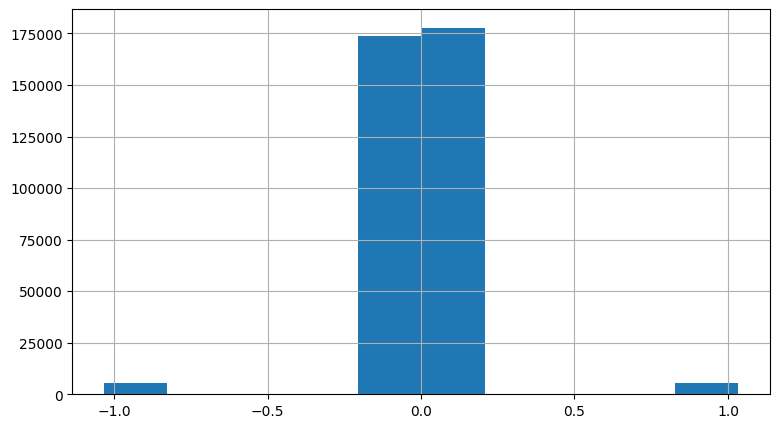

In [14]:
#universe = universe.loc[universe.index<='2023-05-25 23:00:00']
universe['alpha_111'].hist()

### 构造评估数据

In [77]:
import random
universe = universe.sort_values(by=['date','ts_code'])
all_factors = universe.copy(deep=True)
start_time = '2022-11-01 00:00:00'
end_time = '2023-03-01 00:00:00'
all_factors = all_factors.loc[(all_factors.index>=start_time) & (all_factors.index<=end_time)]
def return_handle(df):
    df['returns_2'] = df['log-ret'].shift(-1)
    noise_list = []
    for i in range(df.shape[0]):
        noise = abs(random.gauss(0, 0.02))
        if noise > 0.02:
            noise=0.005
        noise_list.append(noise)
    df['returns_2'] = df['returns_2'] + np.array(noise_list)*df['vwap'].pct_change().shift(-1).fillna(0.)
    return df
all_factors = all_factors.groupby('ts_code').apply(return_handle)
all_factors = all_factors.replace([np.inf, -np.inf], np.nan).fillna(0.).sort_values(by=['date', 'ts_code'])
print(universe.shape, all_factors.shape)

(363909, 49) (99835, 50)


In [78]:
def keep_top_bottom(df, features, bottom=0.35, top=0.65):
    def cal_(data):
        for feature in features:
            tv = data[feature].quantile(top)
            bv = data[feature].quantile(bottom)
            data[feature] = pd.Series(np.where(data[feature]>=tv, data[feature], 
                                               np.where(data[feature]<=bv, data[feature], 0)), index=data.index)
        return data
    
    all_df = pd.DataFrame()
    for dt in tqdm(df.index.unique()):
        tmp = df.loc[df.index == dt]
        all_df = all_df.append(cal_(tmp))
    return all_df.sort_values(by=['date', 'ts_code'])


def wins(x,a,b):
    return np.where(x <= a,a, np.where(x >= b, b, x))

def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n, name):
    return list(filter(lambda x: name in x, n))

def estimate_factor_returns(df, name='alpha_'): 
    ## winsorize returns for fitting 
    estu = df.copy(deep=True)
    estu['returns_2'] = wins(estu['returns_2'], -0.2, 0.2)
    #all_factors = factors_from_names(list(df), name)
    results = pd.Series()
    for factor_name in factor_names:
        form = get_formula([factor_name], "returns_2")
        model = ols(form, data=estu)
        result = model.fit()
        results = results.append(result.params)
    return results

In [79]:
base_field = ['ts_code', 'log-ret', 'open', 'high', 'low', 'close', 'volume', 'vwap','trade_date']
date_and_code = [ 'ts_code', 'returns_2']

alpha_df = all_factors[factor_names + date_and_code].copy(deep=True)
#alpha_df = alpha_df.loc[alpha_df.index<=start_time]
calendar = alpha_df.index.unique() # int64

alpha_df = keep_top_bottom(alpha_df, factor_names)

### 方法1
线性回归评估

In [80]:
### ols to estimate 
facret = {}
for dt in tqdm(calendar, desc='regression factor returns'):
    facret[dt] = estimate_factor_returns(alpha_df.loc[alpha_df.index==dt])

regression factor returns: 100%|████████████| 2881/2881 [07:18<00:00,  6.56it/s]


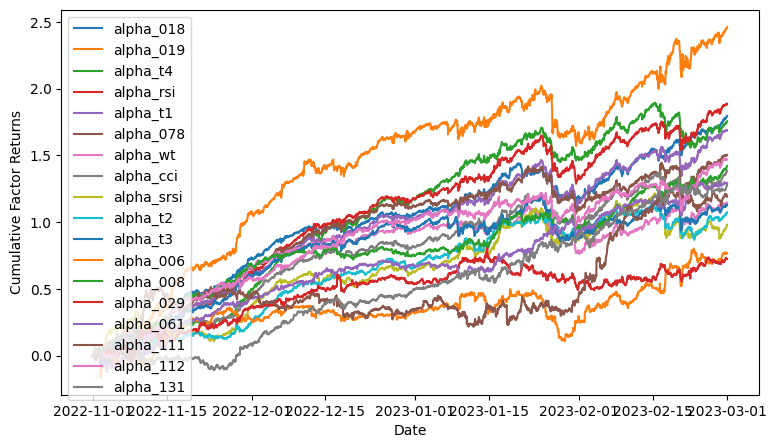

In [88]:
### plot
date_list = alpha_df.index.unique()
facret_df = pd.DataFrame(index = date_list)

for ii, dt in zip(calendar,date_list): 
    for alp in factor_names: 
        facret_df.at[dt, alp] = facret[ii][alp]

# excellent 'alpha_019', 'alpha_018', 'alpha_t3', 'alpha_rsi', 'alpha_022','alpha_078',
display_field  = [
        'alpha_018', 'alpha_019', 'alpha_t4', 'alpha_rsi', 'alpha_t1', 'alpha_078', 
        'alpha_wt','alpha_cci',  'alpha_srsi', 'alpha_t2', 'alpha_t3', 
        'alpha_006', 'alpha_008', 'alpha_029', 'alpha_061', 'alpha_111', 'alpha_112', 'alpha_131'     
]        

for column in display_field:
    plt.plot(facret_df[column].cumsum(), label=column)
    #plt.plot(facret_df[column], label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Factor Returns')
plt.show()

In [87]:
# sharp ratio
np.sqrt(20*252) * (facret_df[display_field].mean())/ facret_df[display_field].std()

alpha_018    5.998678
alpha_019    4.497188
alpha_t4     5.168299
alpha_rsi    5.558202
alpha_t1     4.984959
alpha_078    4.323609
dtype: float64

### 方法2
归一化回报率评估

In [71]:
leverage = 5
costs = 4e-4
df = pd.DataFrame(index=alpha_df.index.unique())
holding_df = pd.DataFrame(index=alpha_df.index.unique())
holding_diff = {}
prev_holding = {}

tmp = alpha_df.loc[alpha_df.index == alpha_df.index.unique()[0]]
for feature in factor_names:
    df.at[dt, feature] = (tmp['returns_2'] * tmp[feature]).sum()/(tmp[feature].abs().sum()) * leverage
    holding_diff[feature] = 1. * leverage * costs
    prev_holding[feature] = tmp[feature] / tmp[feature].abs().sum()

for dt in tqdm(alpha_df.index.unique()[1:]):
    tmp = alpha_df.loc[alpha_df.index == dt]
    for feature in factor_names:
        df.at[dt, feature] = (tmp['returns_2'] * tmp[feature]).sum()/(tmp[feature].abs().sum()) * leverage
        holding_diff[feature] = holding_diff[feature] + \
                                (tmp[feature] / tmp[feature].abs().sum() \
                                 - prev_holding[feature]).abs().sum() / 2 * leverage * costs
        prev_holding[feature] = tmp[feature] / tmp[feature].abs().sum()

100%|███████████████████████████████████████| 2880/2880 [03:06<00:00, 15.48it/s]


<AxesSubplot:xlabel='date'>

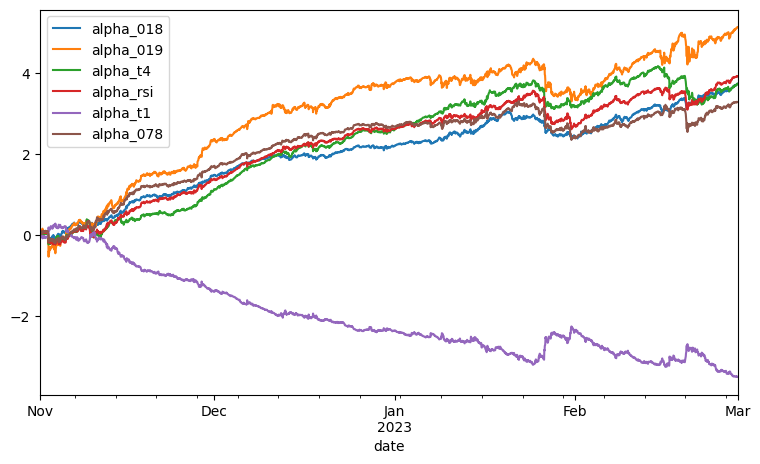

In [83]:
### plot

display_field  = [ 
        'alpha_018', 'alpha_019', 'alpha_t4', 'alpha_rsi', 'alpha_t1', 'alpha_078', 
        #'alpha_wt','alpha_cci',  'alpha_srsi', 'alpha_t2', 'alpha_t3', 
        #'alpha_006', 'alpha_008', 'alpha_029', 'alpha_061', 'alpha_111', 'alpha_112', 'alpha_131'
        ]
df[display_field].cumsum().plot()

In [73]:
# sharp ratio
np.sqrt(22*252) * df[display_field].mean()/ df[display_field].std()

alpha_018    6.112872
alpha_019    4.076788
alpha_t4     4.736398
alpha_rsi    4.943866
alpha_t1    -4.450166
alpha_078    4.094604
dtype: float64

### 方法3
alphalens estimate

In [89]:
universe = universe.sort_values(by=['date','ts_code'])
universe_est = universe.copy(deep=True)
start_time = '2023-01-01 00:00:00'
universe_est = universe_est.loc[universe_est.index >= start_time]
universe_est.index.unique()

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               ...
               '2023-05-25 14:00:00', '2023-05-25 15:00:00',
               '2023-05-25 16:00:00', '2023-05-25 17:00:00',
               '2023-05-25 18:00:00', '2023-05-25 19:00:00',
               '2023-05-25 20:00:00', '2023-05-25 21:00:00',
               '2023-05-25 22:00:00', '2023-05-25 23:00:00'],
              dtype='datetime64[ns]', name='date', length=3479, freq=None)

In [90]:
# dates = pd.date_range(end=pd.to_datetime('2023-03-29 00:00:00', format='%Y-%m-%d %H:%M:%S'), 
#                       periods=len(universe_est.index.unique()), freq='D')
dates = pd.date_range(end=pd.Timestamp('2023-05-26 00:00:00'), 
                      periods=len(universe_est.index.unique()), freq='D')
dates

DatetimeIndex(['2013-11-16', '2013-11-17', '2013-11-18', '2013-11-19',
               '2013-11-20', '2013-11-21', '2013-11-22', '2013-11-23',
               '2013-11-24', '2013-11-25',
               ...
               '2023-05-17', '2023-05-18', '2023-05-19', '2023-05-20',
               '2023-05-21', '2023-05-22', '2023-05-23', '2023-05-24',
               '2023-05-25', '2023-05-26'],
              dtype='datetime64[ns]', length=3479, freq='D')

In [91]:
df = pd.DataFrame()
for ts_code in universe_est.ts_code.unique():
    tmp = universe_est.loc[universe_est.ts_code==ts_code]
    tmp['fake_date'] = dates[(len(universe_est.index.unique()) - tmp.shape[0]):]
    df = df.append(tmp)
df = df.sort_values(by=['date','ts_code'])

In [92]:
#factor_names = ['alpha_078', 'alpha_019','alpha_022', 'alpha_AI', 'returns_2', 'residual']
all_factors = df.copy(deep=True)\
            [factor_names + ['fake_date','ts_code','close', 'log-ret']]
all_factors.reset_index(drop=True, inplace=True)
#all_factors['date'] = pd.to_datetime(all_factors['fake_date'], format='%Y-%m-%d')
all_factors['date'] = all_factors['fake_date'].apply(lambda x: pd.Timestamp(x))
all_factors = all_factors.set_index(['date','ts_code']).sort_values(by=['date', 'ts_code'])
print(all_factors.shape)

(121765, 28)


In [93]:
import alphalens as al
from scipy.stats import zscore
import helper.project_helper as ph

shift_day = -1
tmp = df.copy(deep=True)
tmp['close'] = tmp.groupby('ts_code')['close'].shift(shift_day)
all_pricing = tmp.reset_index().pivot(index='fake_date', columns='ts_code', values='close')
#all_pricing = all_pricing.loc[all_pricing.index[::5]]

def show_sample_results(factors_with_alpha, features, pricing=all_pricing, holding_time=1):
    factors_with_alpha = factors_with_alpha[features]
    
    # Setup data for AlphaLens
    print('Cleaning Data...\n')
    factor_data = ph.build_factor_data(factors_with_alpha, pricing, holding_time=holding_time)
    print('\n-----------------------\n')
    
    # Calculate Factor Returns and Sharpe Ratio
    factor_returns = ph.get_factor_returns(factor_data)
    sharpe_ratio = np.sqrt(252 * 20) * factor_returns.mean() / factor_returns.std()
    
    # Show Results
    print('             Sharpe Ratios')
    print(sharpe_ratio.round(2))
    ph.plot_factor_returns(factor_returns)
    ph.plot_factor_rank_autocorrelation(factor_data)
    
    qr_factor_returns = pd.DataFrame()
    for factor, factor_data in factor_data.items():
        qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0]

    (10000*qr_factor_returns).plot.bar(
        subplots=True,
        sharey=True,
        layout=(8,2),
        figsize=(12, 8),
        legend=False)

#all_pricing.head()

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

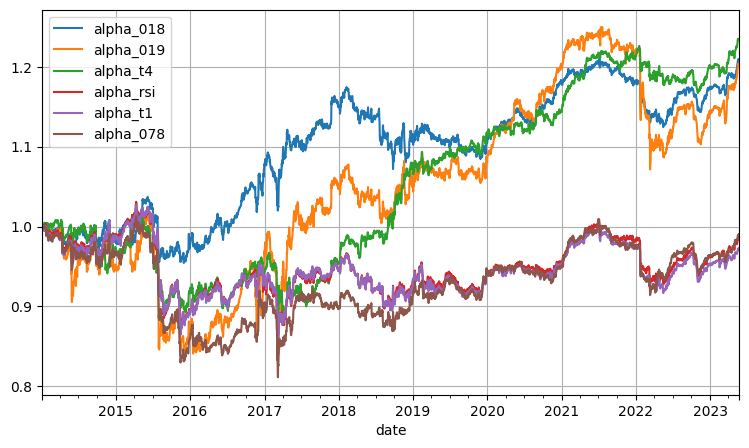

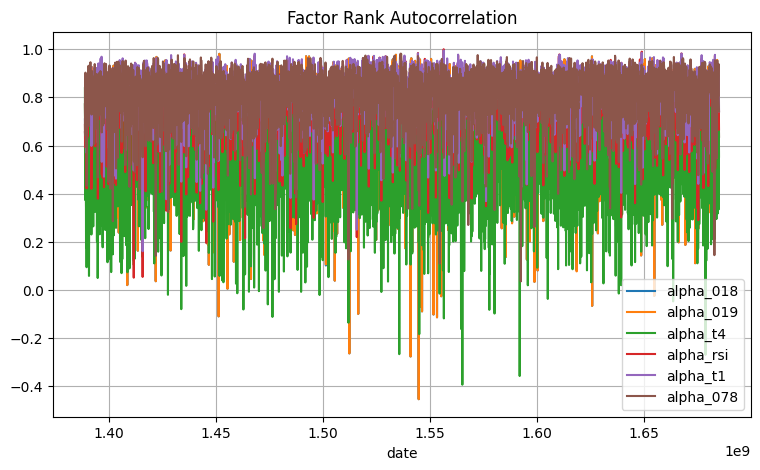

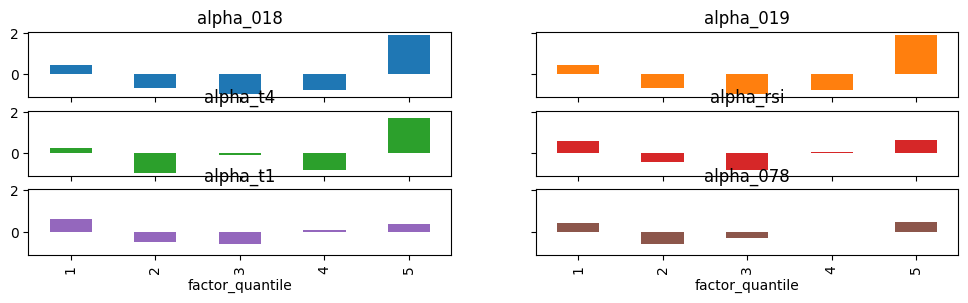

In [96]:
features = [
        'alpha_018', 'alpha_019', 'alpha_t4', 'alpha_rsi', 'alpha_t1', 'alpha_078', 
        #'alpha_wt','alpha_cci',  'alpha_srsi', 'alpha_t2', 'alpha_t3', 
        #'alpha_006', 'alpha_008', 'alpha_029', 'alpha_061', 'alpha_111', 'alpha_112', 'alpha_131'
        ]
cond1 = all_factors['fake_date']>'2014-01-01'
cond2 = all_factors['fake_date']<'2023-06-01'
eva_df = all_factors.loc[cond1 & cond2]
show_sample_results(eva_df, features, pricing=all_pricing, holding_time=1)

In [ ]:
test = all_factors.loc[all_factors.index.get_level_values(0)>'2016-04-01']
factor_data = ph.build_factor_data(test[['alpha_028', 'alpha_ppo', 'alpha_112']], 
                                   all_pricing, holding_time=6)
#al.tears.create_returns_tear_sheet(factor_data['alpha_atr'], long_short=False, group_neutral=False, by_group=False)

In [ ]:
al.tears.create_information_tear_sheet(factor_data['alpha_028'])

### save result

In [97]:
universe

,open_usdt,high_usdt,low_usdt,close_usdt,volume,amount,trade_counts,buy_volume,buy_amount,ts_code,...,alpha_019,alpha_021,alpha_029,alpha_061,alpha_078,alpha_101,alpha_111,alpha_112,alpha_131,alpha_176
date,,,,,,,,,,,,,,,,,,,,,
2022-03-01 00:00:00,0.04827,0.04859,0.04738,0.04742,4.993857e+06,2.403098e+05,1499.0,2.218197e+06,1.067667e+05,ACHUSDT,...,NaN,NaN,NaN,-0.558416,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:00:00,0.94000,0.95100,0.92800,0.93000,2.882661e+07,2.711089e+07,35314.0,1.511524e+07,1.423383e+07,ADAUSDT,...,NaN,NaN,NaN,-0.134790,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:00:00,29.72000,29.87000,28.94000,29.07000,3.708739e+05,1.088847e+07,23433.0,1.807383e+05,5.308529e+06,ATOMUSDT,...,NaN,NaN,NaN,-0.288836,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:00:00,81.87000,82.35000,78.95000,79.50000,3.460654e+05,2.795618e+07,35834.0,1.657856e+05,1.340024e+07,AVAXUSDT,...,NaN,NaN,NaN,-0.481393,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:00:00,382.80000,385.80000,381.40000,382.50000,6.692711e+04,2.568188e+07,31338.0,3.153323e+04,1.210266e+07,BNBUSDT,...,NaN,NaN,NaN,-0.057767,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-25 23:00:00,0.58200,0.58440,0.57760,0.57840,3.134302e+05,1.819735e+05,929.0,1.335978e+05,7.758350e+04,STXUSDT,...,-0.096363,-0.184237,-0.077426,0.077558,0.105208,0.002448,-0.082507,0.183583,0.086562,-0.523396
2023-05-25 23:00:00,0.07767,0.07784,0.07725,0.07733,1.391730e+07,1.078756e+06,3910.0,5.796174e+06,4.494506e+05,TRXUSDT,...,-0.374491,0.058441,-0.096825,-0.349013,-0.220360,-0.190632,-0.074262,-0.139868,-0.176537,0.105240
2023-05-25 23:00:00,2.02700,2.04100,2.00500,2.00800,2.190347e+05,4.422278e+05,1735.0,8.046300e+04,1.625105e+05,UMAUSDT,...,-0.978481,0.244980,-0.509683,-0.698025,-0.968904,0.114757,-0.082532,-0.355720,0.197301,-0.520638


In [98]:
features = ['ts_code', 'log-ret', 'open', 'high', 'low', 'close', 'volume',  'vwap', 'trade_date', 
           'alpha_018', 'alpha_019', 'alpha_t4', 'alpha_rsi', 'alpha_t1', 'alpha_078', 
            'alpha_wt','alpha_cci',  'alpha_srsi', 'alpha_t2', 'alpha_t3', 
            'alpha_006', 'alpha_008', 'alpha_029', 'alpha_061', 'alpha_111', 'alpha_112', 'alpha_131'
           ]

save_date = universe.loc[universe.index>='2022-07-01 00:00:00']
save_date[features].reset_index().to_feather('bitcoin_data/36_zscore.feather')

In [99]:
save_date[features].index.unique()

DatetimeIndex(['2022-07-01 00:00:00', '2022-07-01 01:00:00',
               '2022-07-01 02:00:00', '2022-07-01 03:00:00',
               '2022-07-01 04:00:00', '2022-07-01 05:00:00',
               '2022-07-01 06:00:00', '2022-07-01 07:00:00',
               '2022-07-01 08:00:00', '2022-07-01 09:00:00',
               ...
               '2023-05-25 14:00:00', '2023-05-25 15:00:00',
               '2023-05-25 16:00:00', '2023-05-25 17:00:00',
               '2023-05-25 18:00:00', '2023-05-25 19:00:00',
               '2023-05-25 20:00:00', '2023-05-25 21:00:00',
               '2023-05-25 22:00:00', '2023-05-25 23:00:00'],
              dtype='datetime64[ns]', name='date', length=7895, freq=None)